In [1]:
from MIXIRT import *
from helpers import Cor, MSE, recovery_plot, empty_directory
from data import *

from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import time

import os
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import shutil
import yaml
import sys

# Read in configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['Configs']

def cov2cor(cov_matrix):
    """
    Convert a covariance matrix to a correlation matrix.

    Parameters:
    cov_matrix (np.ndarray): A square covariance matrix.

    Returns:
    np.ndarray: The corresponding correlation matrix.
    """
    # Compute the standard deviations
    stddev = np.sqrt(np.diag(cov_matrix))

    # Outer product of standard deviations
    outer_stddev = np.outer(stddev, stddev)

    # Create the correlation matrix
    cor_matrix = cov_matrix / outer_stddev

    # Fix any numerical issues that may have resulted in slightly off-diagonal values
    np.fill_diagonal(cor_matrix, 1)

    return cor_matrix


def Cor(x, y):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    mu_x = x.mean(1)
    mu_y = y.mean(1)
    n = x.shape[1]
    if n != y.shape[1]:
        raise ValueError('x and y must ' +
                         'have the same number of timepoints.')
    s_x = x.std(1, ddof=n - 1)
    s_y = y.std(1, ddof=n - 1)
    cov = np.dot(x,
                 y.T) - n * np.dot(mu_x[:, np.newaxis],
                                  mu_y[np.newaxis, :])
    return cov / np.dot(s_x[:, np.newaxis], s_y[np.newaxis, :])

In [2]:
npi = pd.read_csv('/Users/karel/Downloads/NPI/data.csv')
npi_items = npi.iloc[:, 1:41].values 

# dictionary defining for each item on which factor it loads
stucture_dict = {
 'Q1':'A',
 'Q2':'Ex',
 'Q3':'Ex',
 'Q4':'S',
 'Q5':'Ent',
 'Q6':'Exp',
 'Q7':'Ex',
 'Q8':'A',
 'Q9':'S',
 'Q10':'A',
 'Q11':'A',
 'Q12':'A',
 'Q13':'Exp',
 'Q14':'Ent',
 'Q15':'V',
 'Q16':'Exp',
 'Q17':'S-S',
 'Q18':'Ent',
 'Q19':'V',
 'Q20':'Ex',
 'Q21':'S-S',
 'Q22':'S-S',
 'Q23':'Exp',
 'Q24':'Ent',
 'Q25':'Ent',
 'Q26':'S',
 'Q27':'Ent',
 'Q28':'Ex',
 'Q29':'V',
 'Q30':'Ex',
 'Q31':'S-S',
 'Q32':'A',
 'Q33':'A',
 'Q34':'S-S',
 'Q35':'Exp',
 'Q36':'A',
 'Q37':'S',
 'Q38':'Ex',
 'Q39':'S-S',
 'Q40':'S'
}

# create mapping of factors to integers
factors = sorted(set(stucture_dict.values()))
factor_to_index = {factor: i for i, factor in enumerate(factors)}

# Create Q matrix
Q = torch.zeros((40, len(factors)))
for i, item in enumerate(sorted(stucture_dict.keys(), key=lambda x: int(x[1:]))):
    factor = stucture_dict[item]
    j = factor_to_index[factor]
    Q[i, j] = 1


In [3]:
coding= np.array([1,1,1,2,2,1,2,1,2,2,1,1,1,1,2,1,2,2,2,2,1,2,2,1,1,2,1,2,1,1,1,2,1,1,2,1,1,1,1,2])
coding = np.expand_dims(coding, 0)
npi_items = (npi_items == coding).astype(int)

# Initial model fit

In [6]:
dataset = MemoryDataset(npi_items)
train_loader = DataLoader(dataset, cfg['OptimConfigs']['batch_size'], shuffle=True)
test_loader = DataLoader(dataset, batch_size=npi_items.shape[0], shuffle=False)

# repeat the enitre training process n_rep times
best_ll = -float('inf')
for i in range(1):
    # initialize logger and trainer
    logger = CSVLogger("logs", name='_'.join(sys.argv), version=0)
    trainer = Trainer(fast_dev_run=cfg['OptimConfigs']['single_epoch_test_run'],
                      max_epochs=cfg['OptimConfigs']['max_epochs'],
                      min_epochs=cfg['OptimConfigs']['min_epochs'],
                      logger=logger,
                      callbacks=[
                          EarlyStopping(monitor='train_loss',
                                        min_delta=cfg['OptimConfigs']['min_delta'],
                                        patience=cfg['OptimConfigs']['patience'],
                                        mode='min')],
                      enable_progress_bar=True,
                      enable_model_summary=False,
                      detect_anomaly=cfg['OptimConfigs']['detect_anomaly'],
                      accelerator=cfg['OptimConfigs']['accelerator'])

    model = VAE(dataloader=train_loader,
              nitems=npi_items.shape[1],
              learning_rate=cfg['OptimConfigs']['learning_rate'],
              latent_dims=7,
              hidden_layer_size=(40+7)//2,
              qm=Q,
              batch_size=32,
              n_iw_samples=10,
              temperature=cfg['OptimConfigs']['gumbel_temperature'],
              temperature_decay=cfg['OptimConfigs']['gumbel_decay'],
              min_temp=cfg['OptimConfigs']['gumbel_min_temp'],
              beta=1)

    start = time.time()
    trainer.fit(model)
    runtime = time.time() - start

    pi, theta, itempars, ll = model.compute_parameters(npi_items)

    dataset = MemoryDataset(npi_items)
    train_loader = DataLoader(dataset, batch_size=npi_items.shape[0], shuffle=False)
    data= next(iter(train_loader))
    latent_vector = model.encoder(data)
    log_sigma = latent_vector[:,8:(8*2)]
    post_samples = model.fscores(data)[0]

    cov_matrix = torch.einsum('ijk,ijl->jkl', post_samples, post_samples) / (post_samples.shape[0] - 1)

    # Step 4: Convert the covariance matrix to a correlation matrix
    std_dev = torch.sqrt(torch.diagonal(cov_matrix, dim1=-2, dim2=-1)).unsqueeze(-1)
    est_cov_mat = (cov_matrix / (std_dev @ std_dev.transpose(-2, -1))).detach().numpy().mean(0)
    est_cor_mat = np.abs(cov2cor(est_cov_mat))
    
    if ll > best_ll:
        best_ll = ll
        best_model = model
        best_itempars = itempars
        best_pi = pi
        best_theta = theta
        best_cor_mat = est_cor_mat
        best_class_ix = torch.argmax(best_pi, 1)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |                                                 | 0/? [00:00<?, ?it/s]

/var/folders/08/7_7s3c813m1dy7916gxtxvth0000gn/T/ipykernel_28630/3183774218.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x='int0', y='int1', palette='deep')


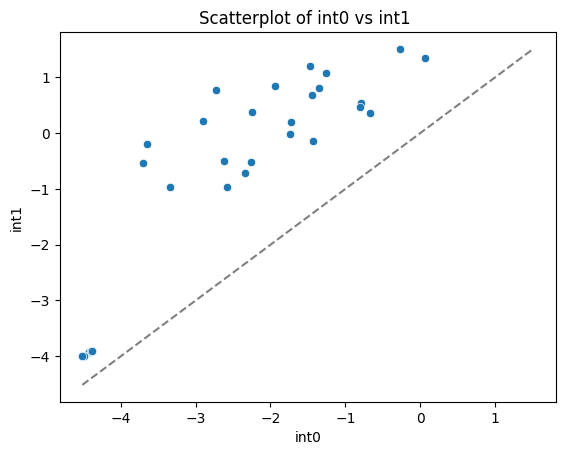

In [6]:
import seaborn as sns
ints = itempars[:,0 ,:]
df = pd.DataFrame({'int0': ints[:,0], 'int1': ints[:,1]})

#flipped = df['int0'] > df['int1']
#df['int0'][flipped] *= -1
#df['int1'][flipped] *= -1

sns.scatterplot(data=df, x='int0', y='int1', palette='deep')

# Add identity line
min_val = min(df['int0'].min(), df['int1'].min())
max_val = max(df['int0'].max(), df['int1'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label='y = x')


plt.title('Scatterplot of int0 vs int1 ')
plt.xlabel('int0')
plt.ylabel('int1')
plt.show()

In [12]:
npi['latent_class'] = pi[:,0] > 0
1-npi.groupby('gender').agg({'latent_class':'mean'})

,latent_class
gender,
0,0.166667
1,0.325292
2,0.213806
3,0.425000


In [13]:
npi.groupby('latent_class').agg({'age':'mean'})
#npi.groupby('latent_class').agg({'age':np.std})

,age
latent_class,
False,29.266944
True,35.844116


In [7]:
est_class = (pi[:,0] > 0).int().numpy()
intercepts = itempars[:, 0, :].numpy()
slopes = itempars[:, 1:, 0].numpy()
np.savetxt('/Users/karel/Documents/GitHub/Discrete_VAEs/results/NPI results/est_class.csv', est_class, delimiter=",")
np.savetxt('/Users/karel/Documents/GitHub/Discrete_VAEs/results/NPI results/est_intercepts.csv', intercepts, delimiter=",")
np.savetxt('/Users/karel/Documents/GitHub/Discrete_VAEs/results/NPI results/est_slopes.csv', slopes, delimiter=",")
np.savetxt('/Users/karel/Documents/GitHub/Discrete_VAEs/Qmatrices/QmatrixNPI.csv', Q.numpy(), delimiter=",")

# Bootstrapping for SEs

In [8]:
from scipy.optimize import linear_sum_assignment
all_itempars = torch.zeros((100, itempars.shape[0], itempars.shape[1],itempars.shape[2]))

n_bootstrap_samples = 100
for sample_ix in range(n_bootstrap_samples):
    print(sample_ix)
    n_samples = npi_items.shape[0]
    bootstrap_indices = torch.randint(0, n_samples, (1, n_samples))
    bootstrap_samples = npi_items[bootstrap_indices, :].squeeze()  # shape: (B, n_samples, n_features)

    dataset = MemoryDataset(bootstrap_samples)
    train_loader = DataLoader(dataset, cfg['OptimConfigs']['batch_size'], shuffle=True)

    logger = CSVLogger("logs", name='_'.join(sys.argv), version=0)
    trainer = Trainer(fast_dev_run=cfg['OptimConfigs']['single_epoch_test_run'],
                      max_epochs=cfg['OptimConfigs']['max_epochs'],
                      min_epochs=cfg['OptimConfigs']['min_epochs'],
                      logger=logger,
                      callbacks=[
                          EarlyStopping(monitor='train_loss',
                                        min_delta=cfg['OptimConfigs']['min_delta'],
                                        patience=cfg['OptimConfigs']['patience'],
                                        mode='min')],
                      enable_progress_bar=True,
                      enable_model_summary=False,
                      detect_anomaly=cfg['OptimConfigs']['detect_anomaly'],
                      accelerator=cfg['OptimConfigs']['accelerator'])
    
    model = VAE(dataloader=train_loader,
              nitems=npi_items.shape[1],
              learning_rate=cfg['OptimConfigs']['learning_rate'],
              latent_dims=7,
              hidden_layer_size=(40+7)//2,
              qm=Q,
              batch_size=32,
              n_iw_samples=10,
              temperature=cfg['OptimConfigs']['gumbel_temperature'],
              temperature_decay=cfg['OptimConfigs']['gumbel_decay'],
              min_temp=cfg['OptimConfigs']['gumbel_min_temp'],
              beta=1)
    
    start = time.time()
    trainer.fit(model)
    runtime = time.time() - start
    
    pi, theta, itempars, ll = model.compute_parameters(npi_items)

    #classcor = Cor(intercepts.T, itempars[:, 0, :].detach().numpy().T)

    cost_matrix = -np.abs(Cor(intercepts.T, itempars[:, 0, :].detach().numpy().T))  # Use abs if signs are flipped
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Now permute itempars to match true classes
    itempars = itempars[:, :, col_ind]

    # deal with label switching
    #if classcor[1,0] > classcor[0,0]:
    #    tmp = itempars[:, :, 0] 
    #    itempars[:, :, 0] = itempars[:, :, 1]
    #    itempars[:, :, 1] = tmp

    # ddeal with flipped thetas
    for dim in range(theta.shape[1]):
        slope_cor = np.corrcoef((slopes[:,dim], itempars[:, dim+1, 0].detach().numpy()))[1,0]
        if slope_cor < 0: 
            itempars[:, dim+1, :] *= -1
    
    all_itempars[sample_ix, :, :, :] = itempars

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


0


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


1


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


3


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


4


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


5


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


6


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


7


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


8


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


9


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


10


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


11


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


12


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


13


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


14


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


15


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


16


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


17


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


18


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


19


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


20


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


21


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


22


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


23


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


24


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


25


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


26


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


27


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


28


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


29


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


30


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


31


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


32


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


33


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


34


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


35


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


36


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


37


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


38


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


39


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


40


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


41


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


42


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


43


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


44


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


45


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


46


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


47


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


48


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


49


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


50


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


51


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


52


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


53


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


54


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


55


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


56


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


57


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


58


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


59


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


60


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


61


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


62


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


63


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


64


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


65


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


66


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


67


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


68


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


69


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


70


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


71


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


72


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


73


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


74


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


75


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


76


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


77


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


78


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


79


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


80


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


81


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


82


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


83


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


84


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


85


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


86


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


87


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


88


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


89


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


90


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


91


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


92


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


93


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


94


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


95


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


96


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


97


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


98


Training: |                                                 | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


99


Training: |                                                 | 0/? [00:00<?, ?it/s]

In [ ]:
1+1

In [39]:
SEs[:,0,1]

tensor([0.6723, 0.9740, 0.7626, 1.3067, 0.9160, 1.1858, 1.5364, 0.8685, 1.6635,
        1.0288, 0.4899, 1.1081, 1.4378, 0.7728, 0.9368, 0.6972, 0.4504, 0.9647,
        1.2442, 1.0720, 0.9078, 0.3137, 1.1308, 0.7298, 1.5183, 0.6770, 1.5323,
        0.8345, 1.0056, 1.7602, 1.0049, 1.2304, 1.1946, 0.9930, 1.5528, 1.4174,
        0.7205, 1.1190, 1.0126, 1.7498])

In [37]:
SEs[:,0, 0]

tensor([0.0833, 0.1166, 0.0917, 0.1788, 0.1112, 0.1457, 0.2132, 0.1069, 0.1746,
        0.1126, 0.0735, 0.1392, 0.1573, 0.0855, 0.1219, 0.0929, 0.0665, 0.1321,
        0.1841, 0.1263, 0.0938, 0.0614, 0.1310, 0.0918, 0.1861, 0.0859, 0.1692,
        0.1133, 0.1189, 0.2165, 0.1222, 0.1136, 0.1256, 0.1353, 0.1675, 0.1752,
        0.0942, 0.1487, 0.1329, 0.1991])

In [9]:
SEs = torch.std(all_itempars, dim=0)

In [15]:
intercept1_est = torch.mean(all_itempars[:, :, 0, 0], dim=0 )
intercept2_est = torch.mean(all_itempars[:, :, 0, 1], dim=0 )
diff = intercept2_est - intercept1_est
SE_pooled = torch.sqrt(SEs[:, 0, 0]**2 + SEs[:, 0, 1]**2)
diff

tensor([1.3378, 1.9477, 1.5156, 2.6383, 1.7931, 2.3470, 3.0233, 1.7428, 3.2115,
        2.0421, 0.9515, 2.1975, 2.8268, 1.4983, 1.8724, 1.3716, 0.8900, 1.9438,
        2.4613, 2.1179, 1.7773, 0.6181, 2.2367, 1.4320, 2.9824, 1.3429, 3.0569,
        1.6348, 1.9959, 3.4406, 1.9502, 2.4720, 2.3959, 1.9453, 3.0548, 2.8233,
        1.4134, 2.1919, 1.9971, 3.3930])

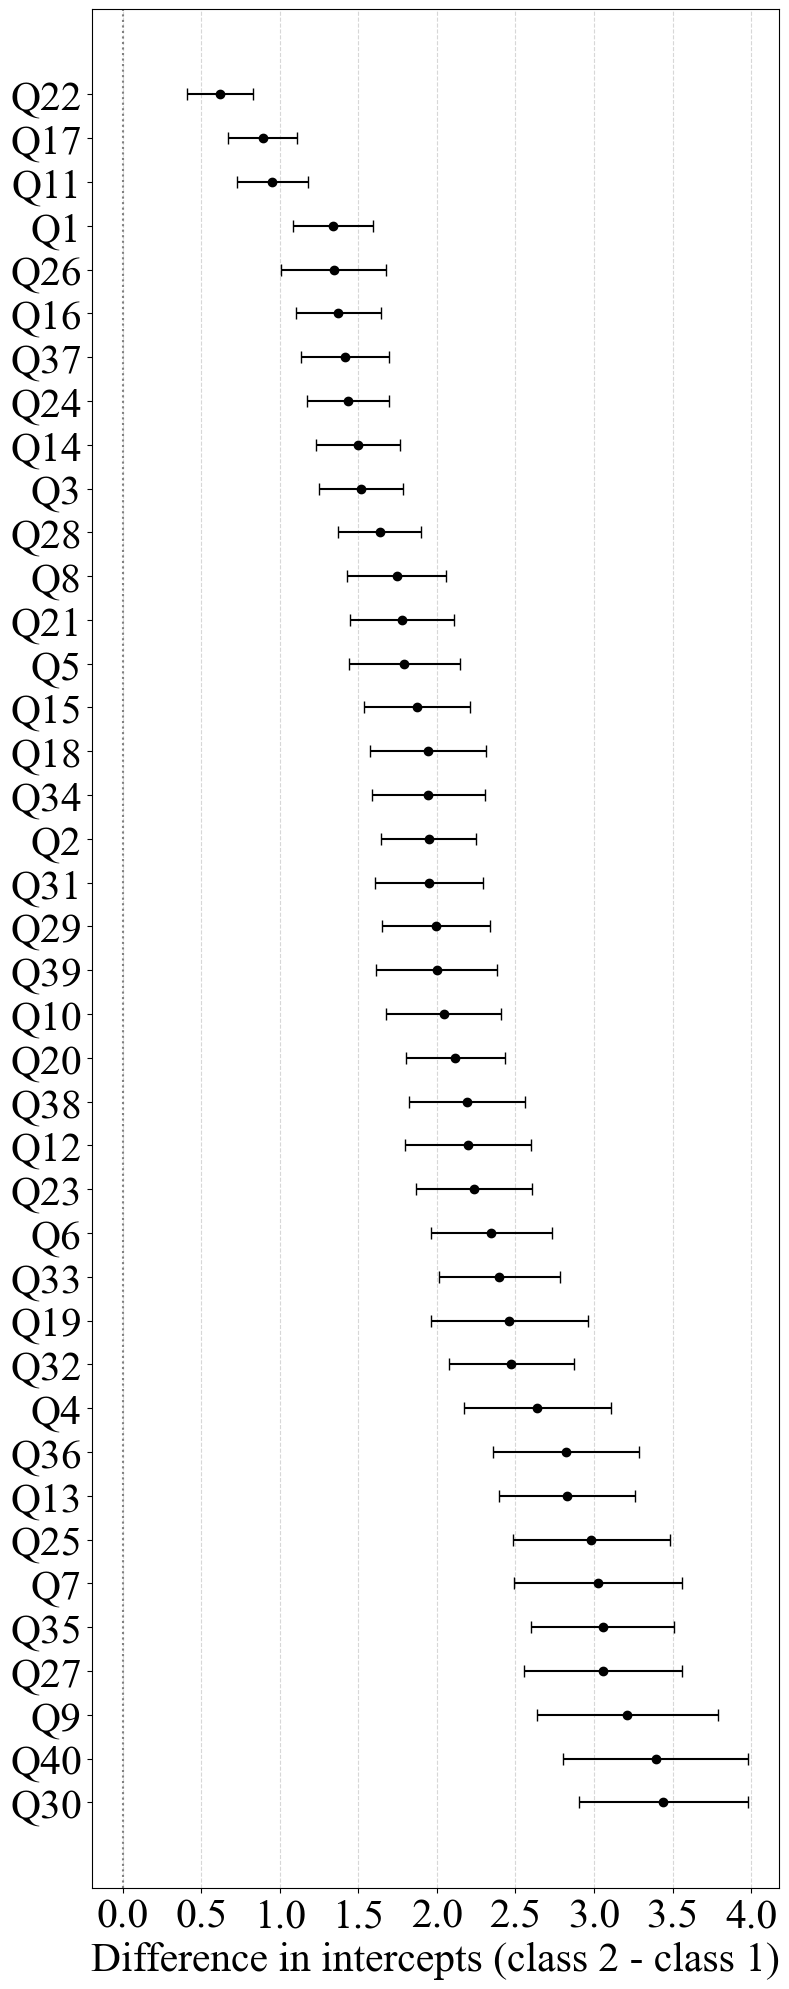

In [34]:
import matplotlib.pyplot as plt
import torch
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Times New Roman'

# Sort by diff
sorted_idx = torch.argsort(-diff)
diff_sorted = diff[sorted_idx]
SE_sorted = SE_pooled[sorted_idx]

# Compute confidence intervals
lower = diff_sorted - 1.96 * SE_sorted
upper = diff_sorted + 1.96 * SE_sorted

# Plot horizontal error bars
plt.figure(figsize=(8, len(diff) * 0.5))
y = torch.arange(len(diff))
plt.errorbar(diff_sorted, y, xerr=1.96 * SE_sorted, fmt='o', capsize=4, label='95% CI', color='black')

# Add vertical line at 0
plt.axvline(0, color='gray', linestyle='dotted')

# Add y-axis labels with larger font size
plt.yticks(y, [f"Q{i.item()+1}" for i in sorted_idx], fontsize=30)

# Axis labels with larger font size
plt.xlabel("Difference in intercepts (class 2 - class 1)", fontsize=30)
plt.ylabel("")  # Remove y-axis label

# Set x-axis tick label font size
plt.xticks(fontsize=30)

plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/karel/Downloads/difplot.png')
plt.show()


In [22]:
npi

,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
0,18,2,2,2,2,1,2,1,2,2,...,1,1,2,2,2,1,2,211,1,50
1,6,2,2,2,1,2,2,1,2,1,...,2,1,2,2,2,2,1,149,1,40
2,27,1,2,2,1,2,1,2,1,2,...,1,2,1,1,2,1,2,168,1,28
3,29,1,1,2,2,2,1,2,1,1,...,1,2,1,2,2,1,1,230,1,37
4,6,1,2,1,1,1,2,1,2,1,...,2,1,2,2,2,0,1,389,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,1,2,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,243,1,24
11239,10,2,2,1,1,1,2,1,1,1,...,2,1,2,1,2,2,1,197,1,39
11240,6,1,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,447,2,33
11241,12,2,2,1,1,1,1,1,1,1,...,1,2,2,2,2,2,1,167,1,24


(-3.7988914700224994, 0.22679935786873104)

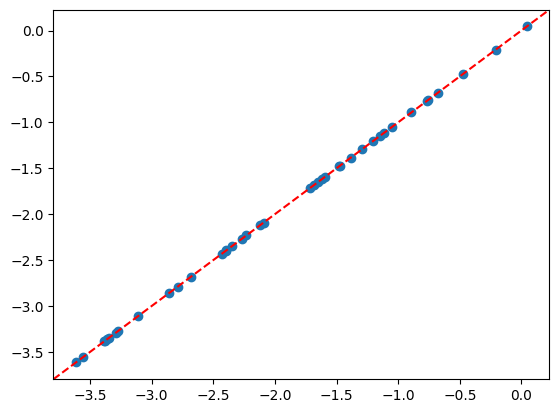

In [70]:
plt.scatter(all_itempars[5, :, 0, 1], all_itempars[5, :, 0, 0])
min_val = min(plt.xlim()[0], plt.ylim()[0])
max_val = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # red dashed identity line
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

In [23]:
np.corrcoef()

array([[ 1., nan, nan, nan, nan, nan, nan],
       [nan,  1., nan, nan, nan, nan, nan],
       [nan, nan,  1., nan, nan, nan, nan],
       [nan, nan, nan,  1., nan, nan, nan],
       [nan, nan, nan, nan,  1., nan, nan],
       [nan, nan, nan, nan, nan,  1., nan],
       [nan, nan, nan, nan, nan, nan,  1.]], dtype=float32)

In [73]:
# Compare along the 40 values for each i
equal_mask = all_itempars[:, :, 0, 0] == all_itempars[:, :, 0, 1]  # shape: [100, 40]

# For each i, check if all 40 elements are equal
all_equal = equal_mask.all(dim=1)  # shape: [100]

# Count how many times this is true across the 100 entries
count_equal = all_equal.sum().item()

count_equal

54

(-3.125871276855469, 0.14885101318359376)

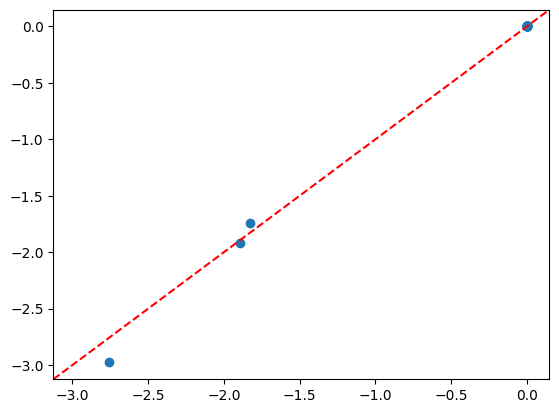

In [255]:
i=6
plt.scatter(itempars[:, i+1, 0], slopes[:, i])
min_val = min(plt.xlim()[0], plt.ylim()[0])
max_val = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([min_val, max_val], [min_val, max_val], 'r--')  # red dashed identity line
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Cross validation for number of clusters

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

n_splits = 5
lls = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(npi_items)):
    print(f"Running fold {fold_idx + 1}/{n_splits}")
    
    # Define training and validation sets
    train_dataset = MemoryDataset(npi_items[train_idx])
    val_dataset = MemoryDataset(npi_items[val_idx])

    train_loader = DataLoader(train_dataset, batch_size=cfg['OptimConfigs']['batch_size'], shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)  # full batch

    logger = CSVLogger("logs", name=f"fold_{fold_idx + 1}", version=0)
    trainer = Trainer(
        fast_dev_run=cfg['OptimConfigs']['single_epoch_test_run'],
        max_epochs=cfg['OptimConfigs']['max_epochs'],
        min_epochs=cfg['OptimConfigs']['min_epochs'],
        logger=logger,
        callbacks=[EarlyStopping(
            monitor='train_loss',
            min_delta=cfg['OptimConfigs']['min_delta'],
            patience=cfg['OptimConfigs']['patience'],
            mode='min')],
        enable_progress_bar=True,
        enable_model_summary=False,
        detect_anomaly=cfg['OptimConfigs']['detect_anomaly'],
        accelerator=cfg['OptimConfigs']['accelerator']
    )

    model = VAE(
        dataloader=train_loader,
        nitems=npi_items.shape[1],
        learning_rate=cfg['OptimConfigs']['learning_rate'],
        latent_dims=7,
        hidden_layer_size=(40 + 7) // 2,
        qm=Q,
        batch_size=cfg['OptimConfigs']['batch_size'],
        n_iw_samples=10,
        temperature=cfg['OptimConfigs']['gumbel_temperature'],
        temperature_decay=cfg['OptimConfigs']['gumbel_decay'],
        min_temp=cfg['OptimConfigs']['gumbel_min_temp'],
        beta=1,
        nclass=2
    )

    start = time.time()
    trainer.fit(model)
    runtime = time.time() - start

    pi, theta, itempars, ll = model.compute_parameters(next(iter(test_loader)))

    lls.append(ll)

np.mean(lls)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 1/5


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 2/5


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 3/5


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 4/5


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 5/5


Training: |                                                     | 0/? [00:00<?, ?it/s]

np.float32(-35506.562)

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

n_splits = 5
lls = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(npi_items)):
    print(f"Running fold {fold_idx + 1}/{n_splits}")
    
    # Define training and validation sets
    train_dataset = MemoryDataset(npi_items[train_idx])
    val_dataset = MemoryDataset(npi_items[val_idx])

    
    train_loader = DataLoader(train_dataset, batch_size=cfg['OptimConfigs']['batch_size'], shuffle=True)
    test_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)  # full batch

    logger = CSVLogger("logs", name=f"fold_{fold_idx + 1}", version=0)
    trainer = Trainer(
        fast_dev_run=cfg['OptimConfigs']['single_epoch_test_run'],
        max_epochs=cfg['OptimConfigs']['max_epochs'],
        min_epochs=cfg['OptimConfigs']['min_epochs'],
        logger=logger,
        callbacks=[EarlyStopping(
            monitor='train_loss',
            min_delta=cfg['OptimConfigs']['min_delta'],
            patience=cfg['OptimConfigs']['patience'],
            mode='min')],
        enable_progress_bar=True,
        enable_model_summary=False,
        detect_anomaly=cfg['OptimConfigs']['detect_anomaly'],
        accelerator=cfg['OptimConfigs']['accelerator']
    )

    model = VAE(
        dataloader=train_loader,
        nitems=npi_items.shape[1],
        learning_rate=cfg['OptimConfigs']['learning_rate'],
        latent_dims=7,
        hidden_layer_size=(40 + 7) // 2,
        qm=Q,
        batch_size=cfg['OptimConfigs']['batch_size'],
        n_iw_samples=10,
        temperature=cfg['OptimConfigs']['gumbel_temperature'],
        temperature_decay=cfg['OptimConfigs']['gumbel_decay'],
        min_temp=cfg['OptimConfigs']['gumbel_min_temp'],
        nclass=1,
        beta=1
    )

    start = time.time()
    trainer.fit(model)
    runtime = time.time() - start

    pi, theta, itempars, ll = model.compute_parameters(next(iter(test_loader)))

    lls.append(ll)

np.mean(lls)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 1/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/fold_1/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/fold_1/version_0/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 2/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/fold_2/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/fold_2/version_0/checkpoints exists and is not empty.


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 3/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/fold_3/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/fold_3/version_0/checkpoints exists and is not empty.


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 4/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/fold_4/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/fold_4/version_0/checkpoints exists and is not empty.


Training: |                                                     | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running fold 5/5


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/fold_5/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/fold_5/version_0/checkpoints exists and is not empty.


Training: |                                                     | 0/? [00:00<?, ?it/s]

np.float32(-36589.54)

In [47]:
col = npi["age"]

range_ = col.max() - col.min()
mean_ = col.mean()
std_ = col.std()

print("Mean:", mean_)
print("Standard Deviation:", std_)

Mean: 34.01423107711465
Standard Deviation: 15.015611051701297


In [46]:
col.min()

np.int64(0)